**Group: Mobility Innovators**

**Group Members:**
- Aquiles Escarra
- Inderjeet Singh
- Aditya Mehta
- Yungvir Singh

**File description:**




## Importing Required Libraries & Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 1: Loading and Overview of the Dataset

In [2]:
# Load traffic volume datasets
df_parking = pd.read_csv('df_parking_hourly.csv')
df_traffic = pd.read_csv('df_volume_expanded.csv')

#Setting up notebook so that all columns are displayed
pd.set_option('display.max_columns', None)

#2: Data Cleaning and Preparation

In [3]:
for i, df in enumerate([df_parking, df_traffic], start=1):
    print(f"\n -> Estructure {i}:")
    print(df.info())


 -> Estructure 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168863 entries, 0 to 168862
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   datetime           168863 non-null  object 
 1   unit               168863 non-null  object 
 2   vehicles_count     168863 non-null  int64  
 3   total_amount       168863 non-null  float64
 4   revenue_generated  168863 non-null  float64
 5   avg_hourly_rate    168863 non-null  float64
 6   avg_duration       168863 non-null  float64
 7   resident_count     168863 non-null  int64  
 8   parking_count      168863 non-null  int64  
 9   extension_count    168863 non-null  int64  
 10  pay_phone_count    168863 non-null  int64  
 11  pay_card_count     168863 non-null  int64  
 12  pay_cash_count     168863 non-null  int64  
 13  resident_ratio     168863 non-null  float64
 14  hour               168863 non-null  int64  
 15  day_of_week        168863 non-nu

## Standardize and Align Datetime Columns

Convert the datetime columns to a consistent datetime format and round to the nearest hour.
This ensures both datasets can be accurately merged by the same hourly timestamps.

In [ ]:
print("Datetime columns standardized.")
df_parking['datetime'] = pd.to_datetime(df_parking['datetime'], errors='coerce')
df_traffic['datetime'] = pd.to_datetime(df_traffic['datetime'], errors='coerce')

print("Parking time range:", df_parking['datetime'].min(), "→", df_parking['datetime'].max(),"Datatype: ", df_parking['datetime'].dtype)
print("Traffic time range:", df_traffic['datetime'].min(), "→", df_traffic['datetime'].max(),"Datatype: ", df_traffic['datetime'].dtype)


Datetime columns standardized.
Parking time range: 2024-01-01 08:00:00 → 2025-09-01 09:00:00 Datatype:  datetime64[ns]
Traffic time range: 2024-01-01 01:00:00 → 2025-09-01 00:00:00 Datatype:  datetime64[ns]


## Exclude months with no data on both datasets

In [ ]:
# 1  Exclude months with no parking data (June–July 2024)
mask_invalid_months = (
    (df_parking['datetime'].dt.year == 2024) &
    (df_parking['datetime'].dt.month.isin([6, 7]))
)
df_parking_clean = df_parking.loc[~mask_invalid_months].copy()

# 2  Exclude traffic sensor downtime (July 9–25 2025)
mask_downtime = (
    (df_traffic['datetime'] >= "2025-07-09 14:00:00") &
    (df_traffic['datetime'] <= "2025-07-25 17:00:00")
)
df_traffic_clean = df_traffic.loc[~mask_downtime].copy()

print(f" Parking dataset after filtering: {df_parking_clean.shape[0]:,} rows")
print(f" Traffic dataset after filtering: {df_traffic_clean.shape[0]:,} rows")


#  Step – Merge Only on Common Period


# Compute valid datetime overlap
start_common = max(df_parking_clean['datetime'].min(), df_traffic_clean['datetime'].min())
end_common   = min(df_parking_clean['datetime'].max(), df_traffic_clean['datetime'].max())

print(f"\n Common datetime range: {start_common} → {end_common}")

# Keep only records inside this shared range
df_parking_final = df_parking_clean[
    (df_parking_clean['datetime'] >= start_common) &
    (df_parking_clean['datetime'] <= end_common)
].copy()

df_traffic_final = df_traffic_clean[
    (df_traffic_clean['datetime'] >= start_common) &
    (df_traffic_clean['datetime'] <= end_common)
].copy()

# Merge (inner join on datetime)
df_parking_traffic = pd.merge(
    df_parking_final,
    df_traffic_final,
    on='datetime',
    how='inner'
)

print(f"\n Final merged dataset shape: {df_parking_traffic.shape}")
print("Null values after merge:")
print(df_parking_traffic.isna().sum().loc[
    lambda s: s[s > 0].index  # only show columns with missing values
])


 Parking dataset after filtering: 168,853 rows
 Traffic dataset after filtering: 14,228 rows

 Common datetime range: 2024-01-01 08:00:00 → 2025-09-01 00:00:00

 Final merged dataset shape: (163033, 24)
Null values after merge:
Series([], dtype: int64)


## Check for Missing Values in Merged Dataset

In [ ]:
# Count missing values
null_counts = df_parking_traffic.isna().sum()

# Calculate percentage of missing values
null_percent = (null_counts / len(df_parking_traffic)) * 100

# Combine into one summary DataFrame
df_nulls_summary = pd.DataFrame({
    'Missing Values': null_counts,
    'Percentage': null_percent.round(2)
})

# Filter to show only columns with missing values
df_nulls_summary = df_nulls_summary[df_nulls_summary['Missing Values'] > 0]

if df_nulls_summary.empty:
    print(" No missing values detected in df_parking_traffic.")
else:
    print(" Columns with missing values:")
    display(df_nulls_summary.sort_values(by='Missing Values', ascending=False))


 No missing values detected in df_parking_traffic.


In [ ]:
print("Merged dataset shape: ",df_parking_traffic.shape)

Merged dataset shape:  (163033, 24)


In [ ]:
df_parking_traffic.describe()

,datetime,vehicles_count,total_amount,revenue_generated,avg_hourly_rate,avg_duration,resident_count,parking_count,extension_count,pay_phone_count,pay_card_count,pay_cash_count,resident_ratio,hour,Bridge_Northbound,Bridge_Southbound,EastEntrance_Northbound,EastEntrance_Southbound,MountainAve_Northbound,MountainAve_Southbound,WestEntrance_Northbound,WestEntrance_Southbound
count,163033,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000,163033.000000
mean,2024-11-08 05:46:03.335030528,17.447952,234.818273,94.296894,5.524432,2.301724,2.683242,16.853036,1.008912,7.978299,9.221477,0.662173,0.092341,14.171634,341.604197,394.896683,244.455435,286.608478,105.502187,111.693725,363.513669,343.650899
min,2024-01-01 08:00:00,1.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-05-15 11:00:00,3.000000,26.000000,14.000000,4.087912,1.735714,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000,11.000000,251.000000,291.000000,158.000000,183.000000,53.000000,67.000000,269.000000,214.000000
50%,2024-11-15 10:00:00,7.000000,80.500000,36.000000,6.000000,2.166667,0.000000,6.000000,0.000000,0.000000,5.000000,0.000000,0.000000,14.000000,328.000000,398.000000,219.000000,257.000000,100.000000,108.000000,348.000000,337.000000
75%,2025-04-11 20:00:00,15.000000,217.500000,88.297521,7.000000,2.693056,1.000000,15.000000,1.000000,0.000000,12.000000,1.000000,0.076923,17.000000,438.000000,502.000000,320.000000,374.000000,157.000000,154.000000,453.000000,470.000000
max,2025-09-01 00:00:00,529.000000,10254.500000,3725.500099,210.000000,12.000000,127.000000,509.000000,74.000000,560.000000,99.000000,21.000000,2.000000,23.000000,691.000000,882.000000,900.000000,881.000000,302.000000,309.000000,792.000000,794.000000
std,NaN,40.429371,567.695788,220.066301,1.956056,1.086821,11.808334,38.532488,3.990930,42.445312,11.327606,1.095283,0.207857,3.961439,126.893306,145.446641,120.882047,144.350795,61.445674,56.365485,143.702772,163.868222


## Data Inspection and Quality Overview

In [ ]:

print("✅ Dataset ready for inspection.\n")

# --- 1️⃣ Basic structure ---
print("🔹 Shape (rows, columns):", df_parking_traffic.shape)
print("🔹 Time range:", df_parking_traffic['datetime'].min(), "→", df_parking_traffic['datetime'].max())
print("🔹 Column list:")
print(df_parking_traffic.columns.tolist(), "\n")

# --- 2️⃣ Data types and memory info ---
print("🧱 Dataset info:")
df_parking_traffic.info()

# --- 3️⃣ Missing values summary ---
print("\n🔍 Missing values per column:")
missing_summary = (
    df_parking_traffic.isna().sum()
    .reset_index()
    .rename(columns={'index': 'column', 0: 'missing'})
)
missing_summary['%_missing'] = (missing_summary['missing'] / len(df_parking_traffic) * 100).round(2)
display(missing_summary.sort_values('%_missing', ascending=False).head(10))

# --- 4️⃣ Duplicate records ---
duplicates = df_parking_traffic.duplicated().sum()
print(f"🧩 Duplicate rows detected: {duplicates}\n")

# --- 5️⃣ Descriptive statistics for numeric features ---
numeric_cols = df_parking_traffic.select_dtypes(include=[np.number]).columns.tolist()
print(f"📊 Numeric columns ({len(numeric_cols)}): {numeric_cols}\n")
display(df_parking_traffic[numeric_cols].describe().T.round(2))

# --- 6️⃣ Quick categorical overview ---
categorical_cols = df_parking_traffic.select_dtypes(exclude=[np.number, 'datetime64']).columns.tolist()
print(f"🔸 Categorical columns ({len(categorical_cols)}): {categorical_cols}\n")

for col in categorical_cols:
    unique_vals = df_parking_traffic[col].nunique()
    print(f"   - {col}: {unique_vals} unique values")
    if unique_vals <= 10:
        print(df_parking_traffic[col].value_counts().head(), "\n")

# --- 7️⃣ Temporal continuity check (hourly increments) ---
time_diffs = df_parking_traffic['datetime'].sort_values().diff().value_counts()
print("\n⌛ Time interval frequency (should be 1 hour):")
display(time_diffs.head())

# --- 8️⃣ Correlation preview ---
if len(numeric_cols) > 1:
    corr_matrix = df_parking_traffic[numeric_cols].corr().round(2)
    print("\n🔗 Correlation matrix (numeric features):")
    display(corr_matrix)
else:
    print("\n⚠️ Not enough numeric columns for correlation analysis.")


✅ Dataset ready for inspection.

🔹 Shape (rows, columns): (163033, 24)
🔹 Time range: 2024-01-01 08:00:00 → 2025-09-01 00:00:00
🔹 Column list:
['datetime', 'unit', 'vehicles_count', 'total_amount', 'revenue_generated', 'avg_hourly_rate', 'avg_duration', 'resident_count', 'parking_count', 'extension_count', 'pay_phone_count', 'pay_card_count', 'pay_cash_count', 'resident_ratio', 'hour', 'day_of_week', 'Bridge_Northbound', 'Bridge_Southbound', 'EastEntrance_Northbound', 'EastEntrance_Southbound', 'MountainAve_Northbound', 'MountainAve_Southbound', 'WestEntrance_Northbound', 'WestEntrance_Southbound'] 

🧱 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163033 entries, 0 to 163032
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datetime                 163033 non-null  datetime64[ns]
 1   unit                     163033 non-null  object        
 2   vehicles_coun

,column,missing,%_missing
0,datetime,0,0.0
1,unit,0,0.0
2,vehicles_count,0,0.0
3,total_amount,0,0.0
4,revenue_generated,0,0.0
5,avg_hourly_rate,0,0.0
6,avg_duration,0,0.0
7,resident_count,0,0.0
8,parking_count,0,0.0
9,extension_count,0,0.0


🧩 Duplicate rows detected: 0

📊 Numeric columns (21): ['vehicles_count', 'total_amount', 'revenue_generated', 'avg_hourly_rate', 'avg_duration', 'resident_count', 'parking_count', 'extension_count', 'pay_phone_count', 'pay_card_count', 'pay_cash_count', 'resident_ratio', 'hour', 'Bridge_Northbound', 'Bridge_Southbound', 'EastEntrance_Northbound', 'EastEntrance_Southbound', 'MountainAve_Northbound', 'MountainAve_Southbound', 'WestEntrance_Northbound', 'WestEntrance_Southbound']



,count,mean,std,min,25%,50%,75%,max
vehicles_count,163033.0,17.45,40.43,1.00,3.00,7.00,15.00,529.0
total_amount,163033.0,234.82,567.70,0.00,26.00,80.50,217.50,10254.5
revenue_generated,163033.0,94.30,220.07,0.00,14.00,36.00,88.30,3725.5
avg_hourly_rate,163033.0,5.52,1.96,0.00,4.09,6.00,7.00,210.0
avg_duration,163033.0,2.30,1.09,0.02,1.74,2.17,2.69,12.0
resident_count,163033.0,2.68,11.81,0.00,0.00,0.00,1.00,127.0
parking_count,163033.0,16.85,38.53,0.00,3.00,6.00,15.00,509.0
extension_count,163033.0,1.01,3.99,0.00,0.00,0.00,1.00,74.0
pay_phone_count,163033.0,7.98,42.45,0.00,0.00,0.00,0.00,560.0
pay_card_count,163033.0,9.22,11.33,0.00,2.00,5.00,12.00,99.0


🔸 Categorical columns (2): ['unit', 'day_of_week']

   - unit: 29 unique values
   - day_of_week: 7 unique values
day_of_week
Saturday    24094
Friday      23778
Sunday      23573
Thursday    23297
Tuesday     22805
Name: count, dtype: int64 


⌛ Time interval frequency (should be 1 hour):


,count
datetime,
0 days 00:00:00,152418
0 days 01:00:00,10418
0 days 12:00:00,194
61 days 09:00:00,1
16 days 05:00:00,1



🔗 Correlation matrix (numeric features):


,vehicles_count,total_amount,revenue_generated,avg_hourly_rate,avg_duration,resident_count,parking_count,extension_count,pay_phone_count,pay_card_count,pay_cash_count,resident_ratio,hour,Bridge_Northbound,Bridge_Southbound,EastEntrance_Northbound,EastEntrance_Southbound,MountainAve_Northbound,MountainAve_Southbound,WestEntrance_Northbound,WestEntrance_Southbound
vehicles_count,1.00,0.93,0.95,-0.05,0.04,0.79,1.00,0.91,0.96,0.13,-0.05,0.13,0.07,0.19,0.19,0.16,0.19,0.19,0.18,0.16,0.18
total_amount,0.93,1.00,0.98,0.05,0.12,0.56,0.93,0.84,0.87,0.22,-0.06,0.02,0.08,0.25,0.25,0.24,0.27,0.25,0.25,0.24,0.25
revenue_generated,0.95,0.98,1.00,0.06,0.06,0.60,0.95,0.86,0.90,0.19,-0.06,0.04,0.09,0.24,0.23,0.22,0.25,0.24,0.23,0.22,0.23
avg_hourly_rate,-0.05,0.05,0.06,1.00,0.02,-0.20,-0.05,-0.07,-0.10,0.20,-0.27,-0.65,0.17,0.22,0.17,0.29,0.23,0.25,0.18,0.24,0.21
avg_duration,0.04,0.12,0.06,0.02,1.00,-0.04,0.04,-0.00,-0.01,0.19,-0.11,-0.14,0.04,0.13,0.15,0.13,0.16,0.14,0.15,0.13,0.14
resident_count,0.79,0.56,0.60,-0.20,-0.04,1.00,0.78,0.78,0.83,-0.15,-0.05,0.33,-0.01,-0.01,-0.00,-0.02,-0.02,-0.03,-0.02,-0.02,-0.01
parking_count,1.00,0.93,0.95,-0.05,0.04,0.78,1.00,0.90,0.96,0.14,-0.05,0.13,0.07,0.19,0.20,0.16,0.19,0.19,0.19,0.17,0.19
extension_count,0.91,0.84,0.86,-0.07,-0.00,0.78,0.90,1.00,0.93,-0.06,-0.09,0.15,0.04,0.10,0.09,0.08,0.10,0.10,0.08,0.08,0.09
pay_phone_count,0.96,0.87,0.90,-0.10,-0.01,0.83,0.96,0.93,1.00,-0.15,-0.11,0.18,0.03,0.07,0.07,0.05,0.06,0.06,0.06,0.06,0.07
pay_card_count,0.13,0.22,0.19,0.20,0.19,-0.15,0.14,-0.06,-0.15,1.00,0.12,-0.25,0.16,0.43,0.44,0.37,0.44,0.44,0.43,0.38,0.42


In [ ]:
df_parking_traffic.head()

,datetime,unit,vehicles_count,total_amount,revenue_generated,avg_hourly_rate,avg_duration,resident_count,parking_count,extension_count,pay_phone_count,pay_card_count,pay_cash_count,resident_ratio,hour,day_of_week,Bridge_Northbound,Bridge_Southbound,EastEntrance_Northbound,EastEntrance_Southbound,MountainAve_Northbound,MountainAve_Southbound,WestEntrance_Northbound,WestEntrance_Southbound
0,2024-01-01 08:00:00,BANFF01- HEALTH UNIT LOT,1,48.0,4.00000,4.000000,12.000000,0,1,0,0,1,0,0.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0
1,2024-01-01 08:00:00,BANFF100-APP,16,152.0,48.07932,3.004958,2.860417,4,16,0,16,0,0,0.25,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0
2,2024-01-01 08:00:00,"BANFF14- MT ROYAL LOT 1 ""EAST""",1,4.0,4.00000,4.000000,1.000000,0,1,0,0,1,0,0.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0
3,2024-01-01 08:00:00,BANFF19- BEAR STREET PARKADE,1,0.0,0.00000,0.000000,2.000000,1,1,0,0,0,1,1.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0
4,2024-01-01 08:00:00,BANFF20- LYNX 100 BLOCK,1,24.0,4.00000,4.000000,6.000000,0,1,0,0,1,0,0.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0


## Incluir weather y tourism features

In [ ]:
# Load the tourism-features CSV
df_tourism = pd.read_csv('banff_tourism_ml_features.csv')
df_weather = pd.read_csv('df_banff_weather.csv')

In [ ]:
df_tourism.head()

,date,day_of_week,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede
0,2024-01-01,0,0,1,1,1,0,0
1,2024-01-02,1,0,0,0,0,0,0
2,2024-01-03,2,0,0,0,0,0,0
3,2024-01-04,3,0,0,0,0,0,0
4,2024-01-05,4,0,0,0,0,0,0


In [ ]:
df_weather.head()

,date,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,has_precip,is_bad_weather
0,2024-01-01,2.3,-5.1,-1.4,0.0,12.0,0,0
1,2024-01-02,-2.1,-8.5,-5.3,0.0,12.0,0,0
2,2024-01-03,-2.8,-8.7,-5.8,0.0,12.0,0,0
3,2024-01-04,0.6,-6.2,-2.8,0.0,12.0,0,0
4,2024-01-05,-0.5,-7.0,-3.7,0.0,12.0,0,0


In [ ]:
df_parking_traffic.columns

Index(['datetime', 'unit', 'vehicles_count', 'total_amount',
       'revenue_generated', 'avg_hourly_rate', 'avg_duration',
       'resident_count', 'parking_count', 'extension_count', 'pay_phone_count',
       'pay_card_count', 'pay_cash_count', 'resident_ratio', 'hour',
       'day_of_week', 'Bridge_Northbound', 'Bridge_Southbound',
       'EastEntrance_Northbound', 'EastEntrance_Southbound',
       'MountainAve_Northbound', 'MountainAve_Southbound',
       'WestEntrance_Northbound', 'WestEntrance_Southbound'],
      dtype='object')

In [ ]:
# 1. PREPARATION
df_master = df_parking_traffic.copy()
df_master['datetime'] = pd.to_datetime(df_master['datetime'])

# --- KEY STEP: GENERATE THE NUMERIC DAY-OF-WEEK HERE ---
# Extract the weekday number:
# 0 = Monday, 1 = Tuesday ... 5 = Saturday, 6 = Sunday
df_master['day_of_week_num'] = df_master['datetime'].dt.dayofweek

# Create date merge key
df_master['date_key'] = df_master['datetime'].dt.floor('D')

# 2. Create date keys for merging (necessary because one dataset is hourly and the others are daily)
df_tourism['date_key'] = pd.to_datetime(df_tourism['date']).dt.floor('D')
df_weather['date_key'] = pd.to_datetime(df_weather['date']).dt.floor('D')

# 2. CLEANING EXTERNAL DATASETS
# Explicitly remove 'day_of_week' and raw 'date' from tourism to avoid merge conflicts
cols_tourism_exclude = ['day_of_week', 'date']
cols_tourism_clean = [c for c in df_tourism.columns if c not in cols_tourism_exclude]
df_tourism_clean = df_tourism[cols_tourism_clean]

# Clean weather features
cols_weather_exclude = ['day_of_week', 'date']
cols_weather_clean = [c for c in df_weather.columns if c not in cols_weather_exclude]
df_weather_clean = df_weather[cols_weather_clean]


# 3. THE MERGE (Clean and conflict-free)
df_final = pd.merge(df_master, df_tourism_clean, on='date_key', how='left')
df_final = pd.merge(df_final, df_weather_clean, on='date_key', how='left')

# Remove auxiliary merge key
df_final.drop(columns=['date_key'], inplace=True)

# Basic NA handling
# df_final = df_final.fillna(0)

print("✅ Final Dataset Ready.")
print("Columns:", df_final.columns.tolist())
print(df_final[['datetime', 'day_of_week_num', 'vehicles_count']].head())


✅ Final Dataset Ready.
Columns: ['datetime', 'unit', 'vehicles_count', 'total_amount', 'revenue_generated', 'avg_hourly_rate', 'avg_duration', 'resident_count', 'parking_count', 'extension_count', 'pay_phone_count', 'pay_card_count', 'pay_cash_count', 'resident_ratio', 'hour', 'day_of_week', 'Bridge_Northbound', 'Bridge_Southbound', 'EastEntrance_Northbound', 'EastEntrance_Southbound', 'MountainAve_Northbound', 'MountainAve_Southbound', 'WestEntrance_Northbound', 'WestEntrance_Southbound', 'day_of_week_num', 'is_weekend', 'is_holiday_AB', 'is_holiday_BC', 'is_holiday_US', 'is_spring_break', 'is_stampede', 'max_temp', 'min_temp', 'mean_temp', 'total_precip', 'snow_on_ground', 'has_precip', 'is_bad_weather']
             datetime  day_of_week_num  vehicles_count
0 2024-01-01 08:00:00                0               1
1 2024-01-01 08:00:00                0              16
2 2024-01-01 08:00:00                0               1
3 2024-01-01 08:00:00                0               1
4 2024-01

In [ ]:
df_final.head()

,datetime,unit,vehicles_count,total_amount,revenue_generated,avg_hourly_rate,avg_duration,resident_count,parking_count,extension_count,pay_phone_count,pay_card_count,pay_cash_count,resident_ratio,hour,day_of_week,Bridge_Northbound,Bridge_Southbound,EastEntrance_Northbound,EastEntrance_Southbound,MountainAve_Northbound,MountainAve_Southbound,WestEntrance_Northbound,WestEntrance_Southbound,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,has_precip,is_bad_weather
0,2024-01-01 08:00:00,BANFF01- HEALTH UNIT LOT,1,48.0,4.00000,4.000000,12.000000,0,1,0,0,1,0,0.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0,0,0,1,1,1,0,0,2.3,-5.1,-1.4,0.0,12.0,0,0
1,2024-01-01 08:00:00,BANFF100-APP,16,152.0,48.07932,3.004958,2.860417,4,16,0,16,0,0,0.25,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0,0,0,1,1,1,0,0,2.3,-5.1,-1.4,0.0,12.0,0,0
2,2024-01-01 08:00:00,"BANFF14- MT ROYAL LOT 1 ""EAST""",1,4.0,4.00000,4.000000,1.000000,0,1,0,0,1,0,0.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0,0,0,1,1,1,0,0,2.3,-5.1,-1.4,0.0,12.0,0,0
3,2024-01-01 08:00:00,BANFF19- BEAR STREET PARKADE,1,0.0,0.00000,0.000000,2.000000,1,1,0,0,0,1,1.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0,0,0,1,1,1,0,0,2.3,-5.1,-1.4,0.0,12.0,0,0
4,2024-01-01 08:00:00,BANFF20- LYNX 100 BLOCK,1,24.0,4.00000,4.000000,6.000000,0,1,0,0,1,0,0.00,8,Monday,87.0,100.0,49.0,49.0,16.0,27.0,147.0,43.0,0,0,1,1,1,0,0,2.3,-5.1,-1.4,0.0,12.0,0,0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163033 entries, 0 to 163032
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   datetime                 163033 non-null  datetime64[ns]
 1   unit                     163033 non-null  object        
 2   vehicles_count           163033 non-null  int64         
 3   total_amount             163033 non-null  float64       
 4   revenue_generated        163033 non-null  float64       
 5   avg_hourly_rate          163033 non-null  float64       
 6   avg_duration             163033 non-null  float64       
 7   resident_count           163033 non-null  int64         
 8   parking_count            163033 non-null  int64         
 9   extension_count          163033 non-null  int64         
 10  pay_phone_count          163033 non-null  int64         
 11  pay_card_count           163033 non-null  int64         
 12  pay_cash_count  

## Transforming Raw Parking Data into Hourly City-Level ML Features

In [ ]:
# 1. DEFINE WHAT TO DO WITH EACH COLUMN
# ---------------------------------------------------------

# A. Columns to SUM (Parking Metrics)
cols_to_sum = [
    'vehicles_count',
    'total_amount',
    'revenue_generated',
    'resident_count',
    'parking_count',
    'pay_phone_count',
    'pay_card_count',
    'pay_cash_count'
]

# B. Columns to KEEP (Context: Weather, Traffic, Holidays, Temporal Features)
# These variables are identical across all lots for the same hour,
# so we use 'first' (take the first value encountered).
cols_context = [
    'hour', 'day_of_week_num',
    'is_weekend', 'is_holiday_AB', 'is_holiday_BC', 'is_holiday_US',
    'is_spring_break', 'is_stampede',
    'max_temp', 'min_temp', 'mean_temp', 'total_precip', 'snow_on_ground',
    'has_precip', 'is_bad_weather',

    # Traffic columns (already city-wide)
    'Bridge_Northbound', 'Bridge_Southbound',
    'EastEntrance_Northbound', 'EastEntrance_Southbound',
    'MountainAve_Northbound', 'MountainAve_Southbound',
    'WestEntrance_Northbound', 'WestEntrance_Southbound'
]

# Aggregation dictionary for the groupby
agg_dict = {col: 'sum' for col in cols_to_sum}
agg_dict.update({col: 'first' for col in cols_context})

# 2. RUN THE AGGREGATION (Collapse to one row per hour)
# ---------------------------------------------------------
print(f"Rows before (Granular): {df_final.shape[0]}")

df_city = df_final.groupby('datetime').agg(agg_dict).reset_index()

# Recalculate global ratios (optional but useful)
# Example: % of residents city-wide
df_city['global_resident_ratio'] = df_city['resident_count'] / df_city['vehicles_count']
df_city['global_resident_ratio'] = df_city['global_resident_ratio'].fillna(0)

print(f"Rows now (Hourly): {df_city.shape[0]}")
print("✅ City-Level Dataset Created (df_city)")
print(df_city[['datetime', 'vehicles_count', 'EastEntrance_Northbound']].head())


Rows before (Granular): 163033
Rows now (Hourly): 10615
✅ City-Level Dataset Created (df_city)
             datetime  vehicles_count  EastEntrance_Northbound
0 2024-01-01 08:00:00              20                     49.0
1 2024-01-01 09:00:00              60                    109.0
2 2024-01-01 10:00:00             151                    156.0
3 2024-01-01 11:00:00             309                    231.0
4 2024-01-01 12:00:00             485                    374.0


# Data Visualization

## Distribution of Vehicle Count per Hour

This histogram shows how many vehicles are typically present per hour across all parking lots and times.
It helps identify whether occupancy levels are normally distributed or skewed — for example, if there are more low-occupancy or high-occupancy hours.

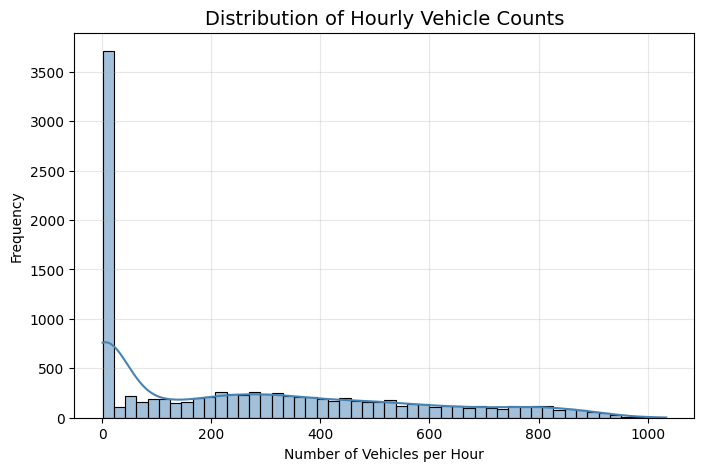

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df_city['vehicles_count'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Hourly Vehicle Counts", fontsize=14)
plt.xlabel("Number of Vehicles per Hour")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

## Top 10 Most Used Parking Lots

/tmp/ipython-input-2727662377.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lot_avg.values, y=lot_avg.index, palette='viridis')


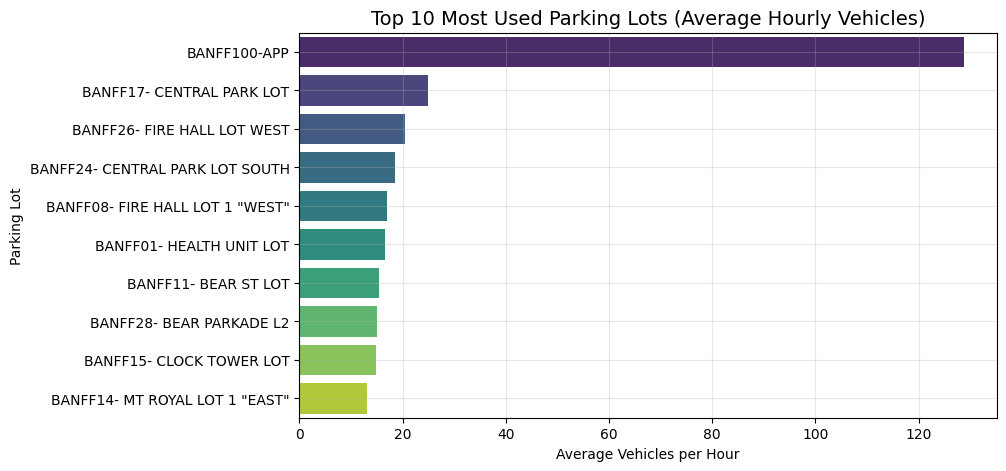

In [ ]:
lot_avg = (
    df_parking_traffic.groupby('unit')['vehicles_count']
    .mean().sort_values(ascending=False).head(10)
)

plt.figure(figsize=(9,5))
sns.barplot(x=lot_avg.values, y=lot_avg.index, palette='viridis')
plt.title("Top 10 Most Used Parking Lots (Average Hourly Vehicles)", fontsize=14)
plt.xlabel("Average Vehicles per Hour")
plt.ylabel("Parking Lot")
plt.grid(alpha=0.3)
plt.show()

## Correlation Between Traffic Volume and Parking Occupancy

This chart compares overall traffic flow (sum across directions) with average parking occupancy per hour.
It reveals if higher traffic volumes lead to fuller parking lots — key for your analysis goal.

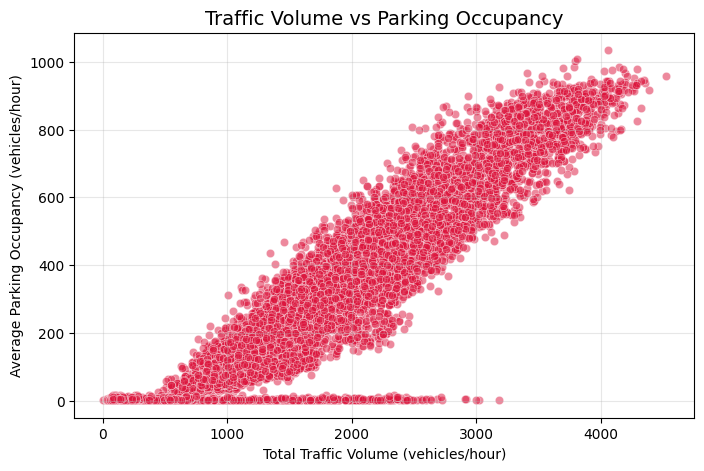

In [ ]:
# Compute total traffic volume across all sensors
traffic_cols = [c for c in df_city.columns if any(x in c.lower() for x in ['northbound','southbound','entrance','bridge','avenue'])]
df_city['total_traffic'] = df_city[traffic_cols].sum(axis=1)

# Aggregate by hour to align averages
hourly_relation = (
    df_city.groupby('datetime')[['vehicles_count','total_traffic']]
    .mean().reset_index()
)

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=hourly_relation,
    x='total_traffic', y='vehicles_count',
    alpha=0.5, color='crimson'
)
plt.title("Traffic Volume vs Parking Occupancy", fontsize=14)
plt.xlabel("Total Traffic Volume (vehicles/hour)")
plt.ylabel("Average Parking Occupancy (vehicles/hour)")
plt.grid(alpha=0.3)
plt.show()

## Hourly Trend of Parking vs Traffic

Shows how parking occupancy and total traffic evolve together through time.
Helps visually confirm synchronization or time-lag effects between road activity and parking demand.

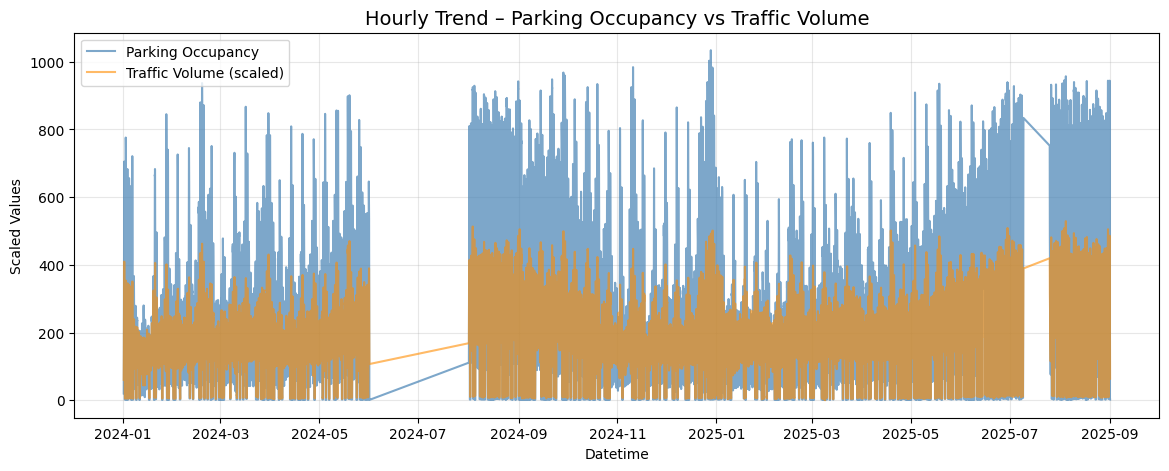

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(df_city['datetime'], df_city['vehicles_count'], label='Parking Occupancy', color='steelblue', alpha=0.7)
plt.plot(df_city['datetime'], df_city['total_traffic']/df_city['total_traffic'].max()*df_parking_traffic['vehicles_count'].max(),
         label='Traffic Volume (scaled)', color='darkorange', alpha=0.6)

plt.title("Hourly Trend – Parking Occupancy vs Traffic Volume", fontsize=14)
plt.xlabel("Datetime")
plt.ylabel("Scaled Values")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Correlation Heatmap (All Numeric Features)

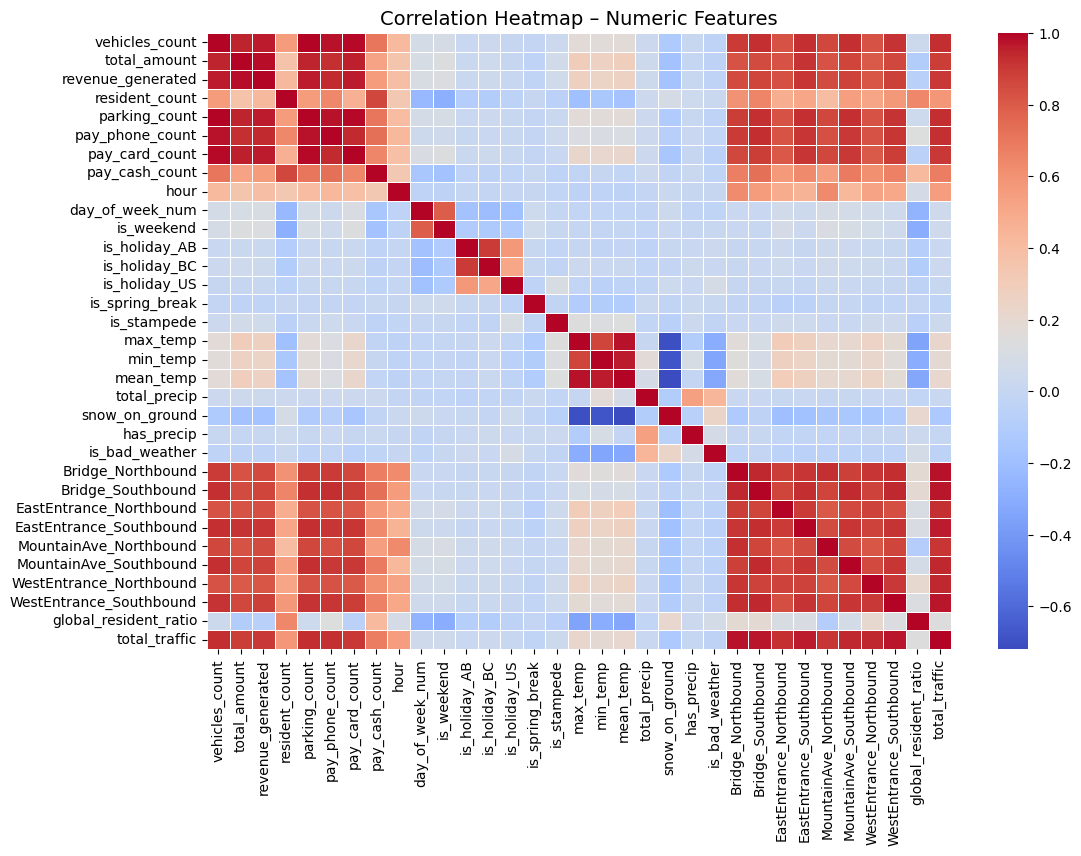

In [ ]:
plt.figure(figsize=(12,8))
sns.heatmap(
    df_city.select_dtypes(include=[np.number]).corr(),
    cmap='coolwarm', annot=False, linewidths=0.5
)
plt.title("Correlation Heatmap – Numeric Features", fontsize=14)
plt.show()

## Monthly Parking Occupancy Trend

This summarizes how average occupancy evolves month by month.
It helps detect seasonal trends such as tourism peaks or low-demand months.

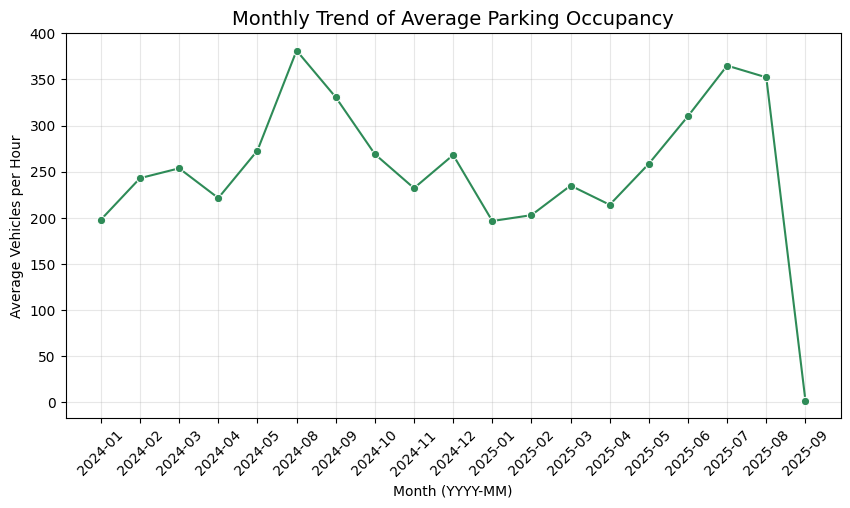

In [ ]:
# Extract year-month as string for better plotting
df_city['month'] = df_city['datetime'].dt.to_period('M').astype(str)

# Compute monthly averages
monthly_avg = (
    df_city.groupby('month')['vehicles_count']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_avg, x='month', y='vehicles_count', marker='o', color='seagreen')
plt.title("Monthly Trend of Average Parking Occupancy", fontsize=14)
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Average Vehicles per Hour")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

## Correlation Between Bridge Traffic and Parking Occupancy

This scatterplot compares hourly bridge traffic volume (northbound + southbound) with average parking occupancy.
It helps determine whether higher bridge traffic is associated with fuller parking lots — a direct traffic-to-parking relationship.

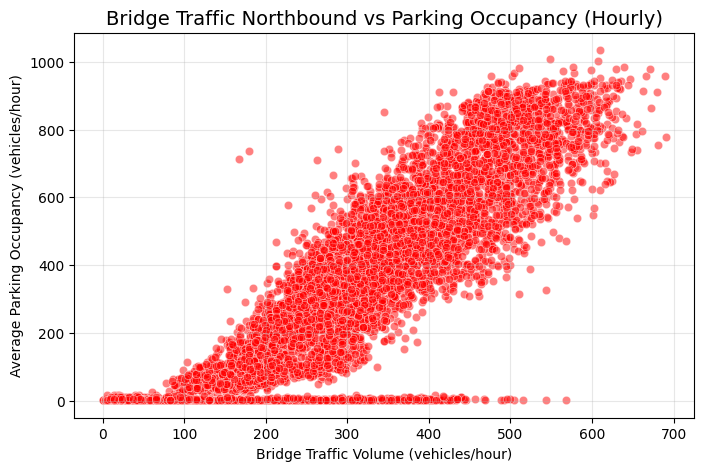

🔗 Pearson correlation between bridge traffic and parking occupancy: 0.89


In [ ]:
# Ensure proper datetime type
df_city['datetime'] = pd.to_datetime(df_city['datetime'])

# --- 1️⃣ Compute total bridge traffic per hour ---
df_city['bridge_total'] = (
    df_city[['Bridge_Northbound']].sum(axis=1)
)

# --- 2️⃣ Aggregate parking data by hour ---
hourly_bridge_relation = (
    df_city.groupby('datetime')[['vehicles_count', 'bridge_total']]
    .mean()
    .reset_index()
)

# --- 3️⃣ Scatterplot: Parking vs Bridge Traffic ---
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=hourly_bridge_relation,
    x='bridge_total', y='vehicles_count',
    alpha=0.5, color='red'
)
plt.title("Bridge Traffic Northbound vs Parking Occupancy (Hourly)", fontsize=14)
plt.xlabel("Bridge Traffic Volume (vehicles/hour)")
plt.ylabel("Average Parking Occupancy (vehicles/hour)")
plt.grid(alpha=0.3)
plt.show()

# --- 4️⃣ Optional: Print correlation coefficient ---
corr_value = hourly_bridge_relation['bridge_total'].corr(hourly_bridge_relation['vehicles_count'])
print(f"🔗 Pearson correlation between bridge traffic and parking occupancy: {corr_value:.2f}")

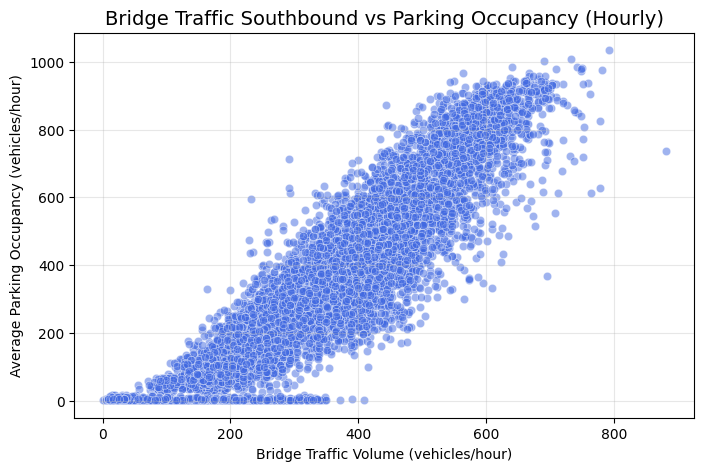

🔗 Pearson correlation between bridge traffic and parking occupancy: 0.92


In [ ]:
# Ensure proper datetime type
df_city['datetime'] = pd.to_datetime(df_city['datetime'])

# --- 1️⃣ Compute total bridge traffic per hour ---
df_city['bridge_total'] = (
    df_city[['Bridge_Southbound']].sum(axis=1)
)

# --- 2️⃣ Aggregate parking data by hour ---
hourly_bridge_relation = (
    df_city.groupby('datetime')[['vehicles_count', 'bridge_total']]
    .mean()
    .reset_index()
)

# --- 3️⃣ Scatterplot: Parking vs Bridge Traffic ---
plt.figure(figsize=(8,5))
sns.scatterplot(
    data=hourly_bridge_relation,
    x='bridge_total', y='vehicles_count',
    alpha=0.5, color='royalblue'
)
plt.title("Bridge Traffic Southbound vs Parking Occupancy (Hourly)", fontsize=14)
plt.xlabel("Bridge Traffic Volume (vehicles/hour)")
plt.ylabel("Average Parking Occupancy (vehicles/hour)")
plt.grid(alpha=0.3)
plt.show()

# --- 4️⃣ Optional: Print correlation coefficient ---
corr_value = hourly_bridge_relation['bridge_total'].corr(hourly_bridge_relation['vehicles_count'])
print(f"🔗 Pearson correlation between bridge traffic and parking occupancy: {corr_value:.2f}")

## Bridge Traffic (Inbound vs Outbound) vs Parking Occupancy by Lot

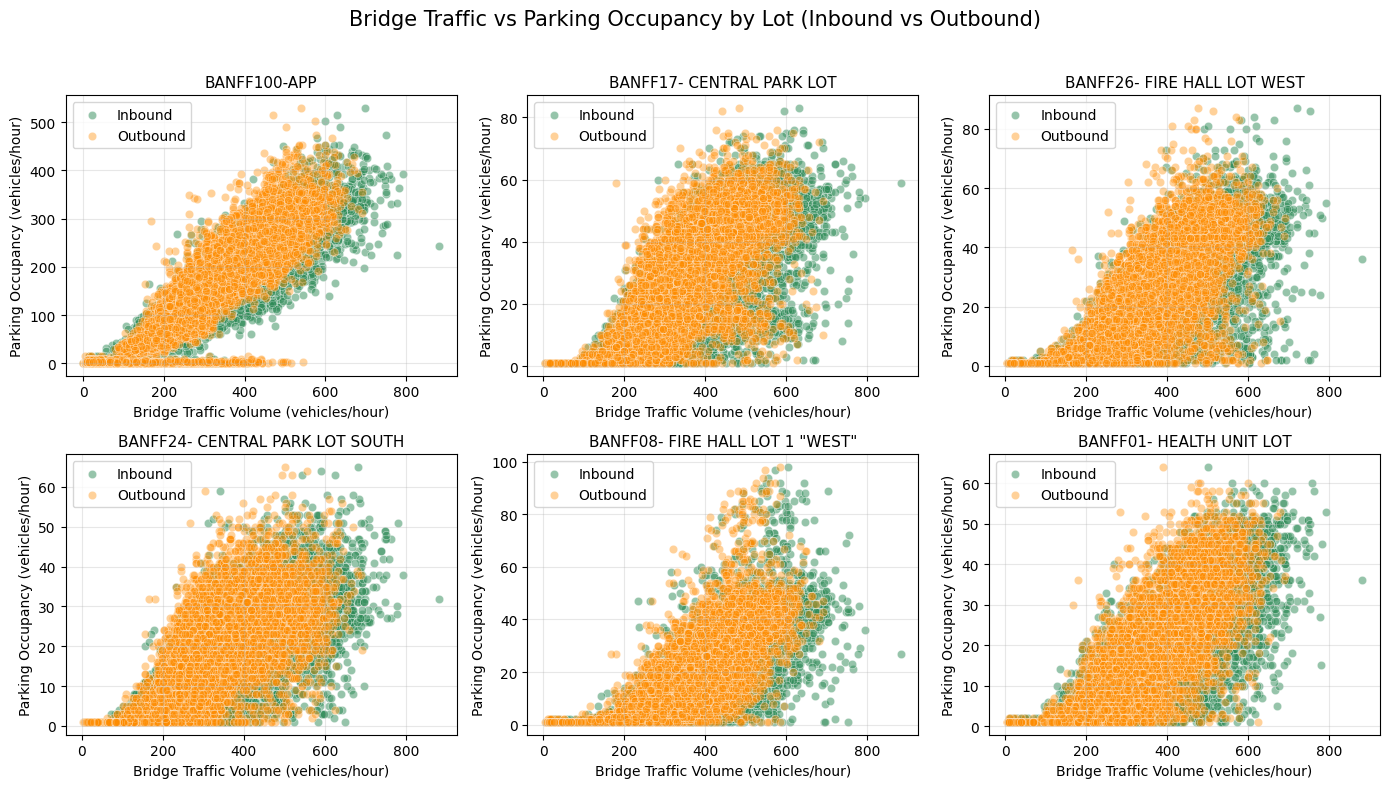

In [ ]:
# --- 1️⃣ Prepare data ---
bridge_relation = (
    df_parking_traffic.groupby(['datetime', 'unit'])
    [['vehicles_count', 'Bridge_Southbound', 'Bridge_Northbound']]
    .mean()
    .reset_index()
)

# --- 2️⃣ Select top 6 busiest lots for readability ---
top_lots = (
    df_parking_traffic.groupby('unit')['vehicles_count']
    .mean()
    .sort_values(ascending=False)
    .head(6)
    .index
)
subset = bridge_relation[bridge_relation['unit'].isin(top_lots)]

# --- 3️⃣ Build the plot grid (two columns per lot: inbound/outbound) ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
axes = axes.flatten()

for i, lot in enumerate(top_lots):
    ax = axes[i]
    data = subset[subset['unit'] == lot]
    sns.scatterplot(data=data, x='Bridge_Southbound', y='vehicles_count',
                    alpha=0.5, color='seagreen', label='Inbound', ax=ax)
    sns.scatterplot(data=data, x='Bridge_Northbound', y='vehicles_count',
                    alpha=0.4, color='darkorange', label='Outbound', ax=ax)
    ax.set_title(lot, fontsize=11)
    ax.set_xlabel("Bridge Traffic Volume (vehicles/hour)")
    ax.set_ylabel("Parking Occupancy (vehicles/hour)")
    ax.grid(alpha=0.3)
    ax.legend()

plt.suptitle("Bridge Traffic vs Parking Occupancy by Lot (Inbound vs Outbound)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Correlation by Direction and Lot

/tmp/ipython-input-1679358935.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


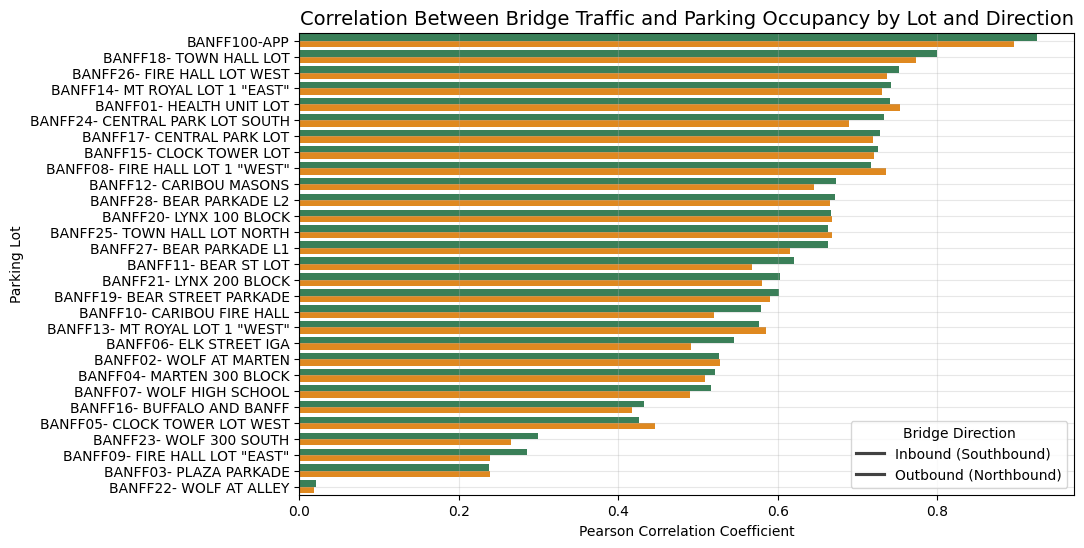

,unit,corr_southbound,corr_northbound
10,BANFF100-APP,0.93,0.90
18,BANFF18- TOWN HALL LOT,0.80,0.77
26,BANFF26- FIRE HALL LOT WEST,0.75,0.74
14,"BANFF14- MT ROYAL LOT 1 ""EAST""",0.74,0.73
0,BANFF01- HEALTH UNIT LOT,0.74,0.75
24,BANFF24- CENTRAL PARK LOT SOUTH,0.73,0.69
17,BANFF17- CENTRAL PARK LOT,0.73,0.72
15,BANFF15- CLOCK TOWER LOT,0.73,0.72
7,"BANFF08- FIRE HALL LOT 1 ""WEST""",0.72,0.74
12,BANFF12- CARIBOU MASONS,0.67,0.65


In [ ]:
# Compute correlation for each lot and each direction separately
corr_by_dir = (
    df_parking_traffic.groupby('unit')
    .apply(lambda x: pd.Series({
        'corr_southbound': x['vehicles_count'].corr(x['Bridge_Southbound']),
        'corr_northbound': x['vehicles_count'].corr(x['Bridge_Northbound'])
    }))
    .reset_index()
    .sort_values('corr_southbound', ascending=False)
)

# Melt for plotting
corr_melted = corr_by_dir.melt(id_vars='unit', var_name='direction', value_name='correlation')

# Plot comparison by lot
plt.figure(figsize=(10,6))
sns.barplot(data=corr_melted, x='correlation', y='unit', hue='direction', palette=['seagreen', 'darkorange'])
plt.title("Correlation Between Bridge Traffic and Parking Occupancy by Lot and Direction", fontsize=14)
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Parking Lot")
plt.legend(title="Bridge Direction", labels=["Inbound (Southbound)", "Outbound (Northbound)"])
plt.grid(alpha=0.3)
plt.show()

# Print table for reference
display(corr_by_dir.round(2))


## Time-Series Comparison: Bridge Traffic vs Parking Occupancy

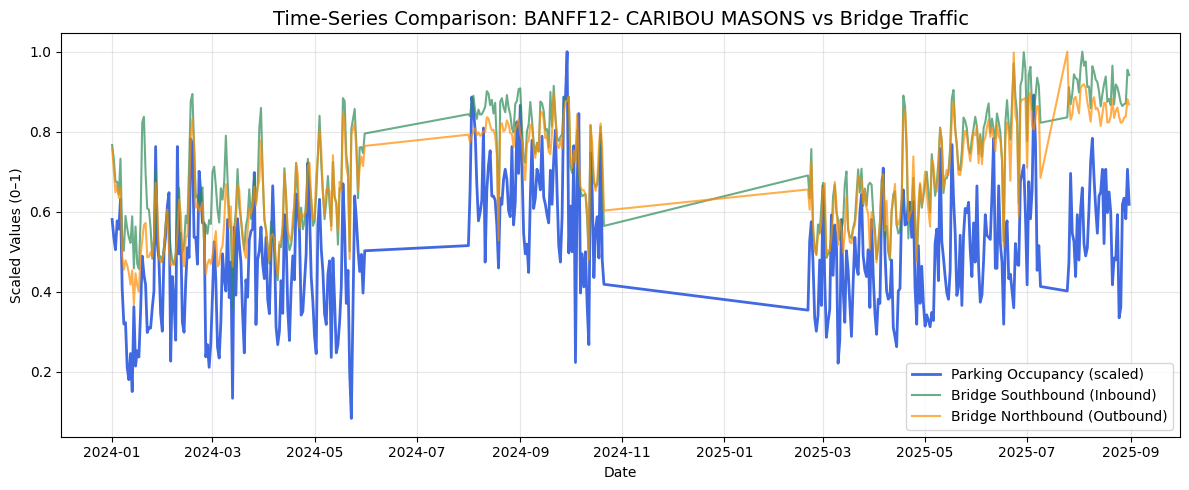

In [ ]:
# Focus on a key lot (e.g., BANFF100-APP, highest correlation)
lot_focus = "BANFF12- CARIBOU MASONS"

# Subset data for that lot
df_focus = df_parking_traffic[df_parking_traffic['unit'] == lot_focus].copy()

# Aggregate to daily averages for clarity
daily_trend = (
    df_focus.groupby(df_focus['datetime'].dt.date)[['vehicles_count', 'Bridge_Southbound', 'Bridge_Northbound']]
    .mean()
    .reset_index()
    .rename(columns={'datetime': 'date'})
)

# Normalize scales for comparison
daily_trend['vehicles_scaled'] = daily_trend['vehicles_count'] / daily_trend['vehicles_count'].max()
daily_trend['bridge_in_scaled'] = daily_trend['Bridge_Southbound'] / daily_trend['Bridge_Southbound'].max()
daily_trend['bridge_out_scaled'] = daily_trend['Bridge_Northbound'] / daily_trend['Bridge_Northbound'].max()

# Plot
plt.figure(figsize=(12,5))
plt.plot(daily_trend['date'], daily_trend['vehicles_scaled'], label='Parking Occupancy (scaled)', color='royalblue', linewidth=2)
plt.plot(daily_trend['date'], daily_trend['bridge_in_scaled'], label='Bridge Southbound (Inbound)', color='seagreen', alpha=0.7)
plt.plot(daily_trend['date'], daily_trend['bridge_out_scaled'], label='Bridge Northbound (Outbound)', color='darkorange', alpha=0.7)

plt.title(f"Time-Series Comparison: {lot_focus} vs Bridge Traffic", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Scaled Values (0–1)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3225147014.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_focus.groupby(df_focus['datetime'].dt.floor('H'))


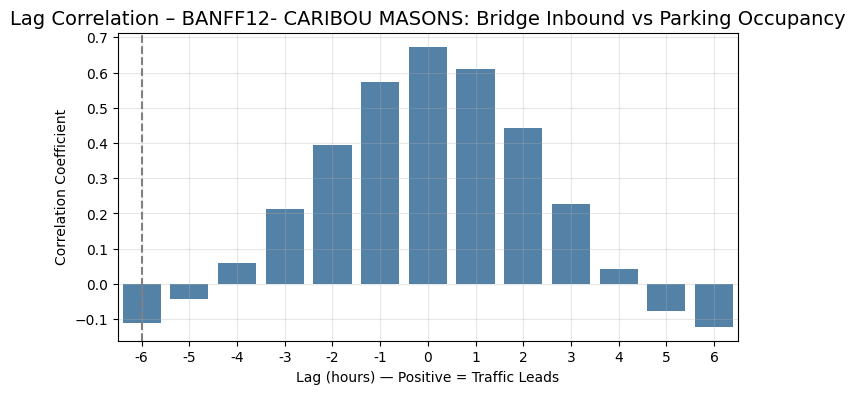

⏱️ Highest correlation at lag = +0 hours (correlation = 0.67)


In [ ]:
# Focus on a specific lot (same as before)
lot_focus = "BANFF12- CARIBOU MASONS"
df_focus = df_parking_traffic[df_parking_traffic['unit'] == lot_focus].copy()

# Aggregate hourly averages to ensure uniform spacing
hourly_data = (
    df_focus.groupby(df_focus['datetime'].dt.floor('H'))
    [['vehicles_count', 'Bridge_Southbound']]
    .mean()
    .dropna()
)

# Compute lag correlations (from -6 to +6 hours)
max_lag = 6
lags = range(-max_lag, max_lag + 1)
corr_values = [
    hourly_data['vehicles_count'].corr(hourly_data['Bridge_Southbound'].shift(lag))
    for lag in lags
]

# Plot correlation by lag
plt.figure(figsize=(8,4))
sns.barplot(x=lags, y=corr_values, color='steelblue')
plt.title(f"Lag Correlation – {lot_focus}: Bridge Inbound vs Parking Occupancy", fontsize=14)
plt.xlabel("Lag (hours) — Positive = Traffic Leads")
plt.ylabel("Correlation Coefficient")
plt.grid(alpha=0.3)
plt.axvline(0, color='gray', linestyle='--')
plt.show()

# Print highest correlation lag
best_lag = lags[np.argmax(corr_values)]
print(f"⏱️ Highest correlation at lag = {best_lag:+d} hours "
      f"(correlation = {max(corr_values):.2f})")


## Hourly Occupancy Pattern by Parking Lot

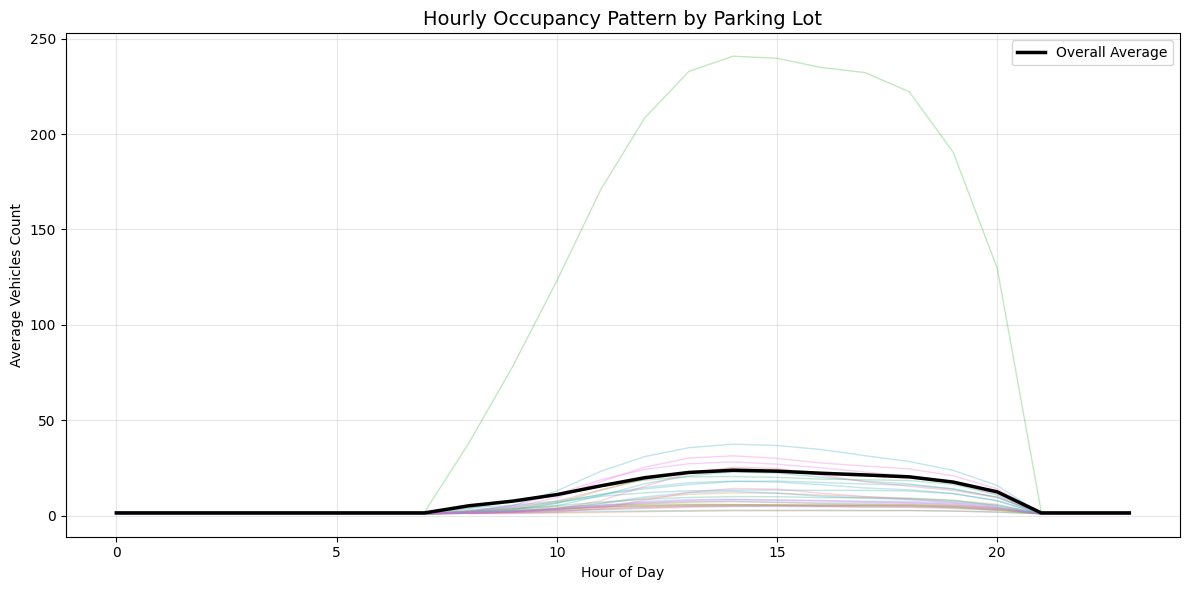

In [ ]:
# Make sure datetime is properly formatted
df_parking_traffic['datetime'] = pd.to_datetime(df_parking_traffic['datetime'], errors='coerce')

# Extract the hour of the day
df_parking_traffic['hour'] = df_parking_traffic['datetime'].dt.hour

# Compute the average number of vehicles per hour and lot
hourly_pattern = (
    df_parking_traffic.groupby(['unit', 'hour'])['vehicles_count']
    .mean()
    .reset_index()
)

# Compute the global hourly average across all lots
overall_hourly_avg = (
    df_parking_traffic.groupby('hour')['vehicles_count']
    .mean()
    .reset_index()
)

# --- Plot ---
plt.figure(figsize=(12,6))
sns.lineplot(
    data=hourly_pattern, x='hour', y='vehicles_count',
    hue='unit', alpha=0.3, linewidth=1, legend=False
)
sns.lineplot(
    data=overall_hourly_avg, x='hour', y='vehicles_count',
    color='black', linewidth=2.5, label='Overall Average'
)

plt.title("Hourly Occupancy Pattern by Parking Lot", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicles Count")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**Daily rhythm**

The black bold line represents the average occupancy across all parking lots.

Parking activity begins around 8:00 a.m., grows rapidly through the morning, and reaches its peak between 1:00 p.m. and 3:00 p.m., corresponding to the main influx of visitors.

After 4:00 p.m., occupancy gradually declines, dropping sharply around 7:00–8:00 p.m. as tourists and commuters leave.

This matches the typical tourism-driven cycle of Banff’s downtown area — morning arrivals, midday saturation, evening departures.

## Variability between lots

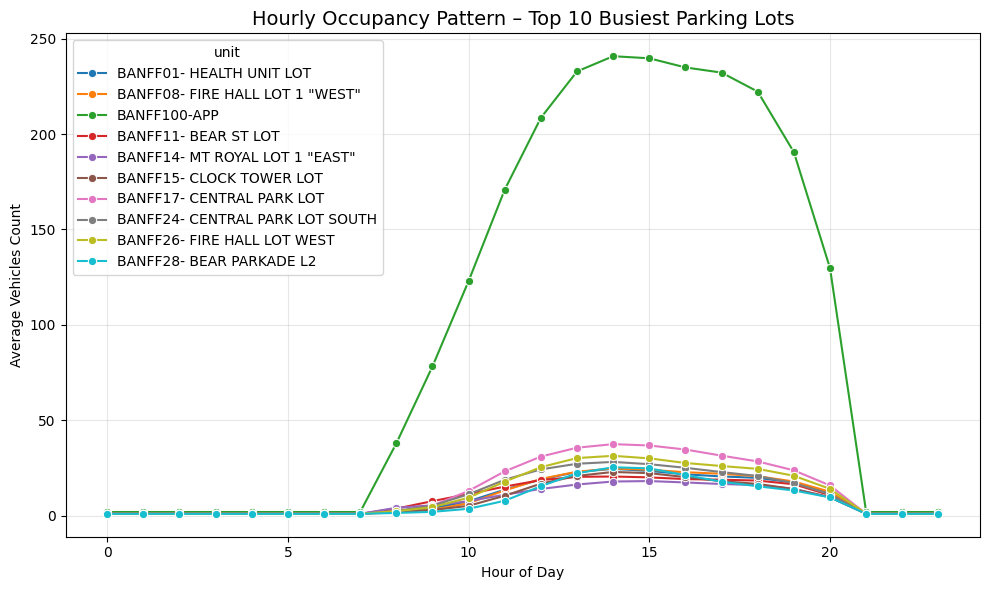

In [ ]:
top10 = (
    df_parking_traffic.groupby('unit')['vehicles_count']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

plt.figure(figsize=(10,6))
sns.lineplot(
    data=hourly_pattern[hourly_pattern['unit'].isin(top10)],
    x='hour', y='vehicles_count', hue='unit', marker='o'
)
plt.title("Hourly Occupancy Pattern – Top 10 Busiest Parking Lots", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicles Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Weekday vs Weekend Occupancy Pattern (All Lots Combined)

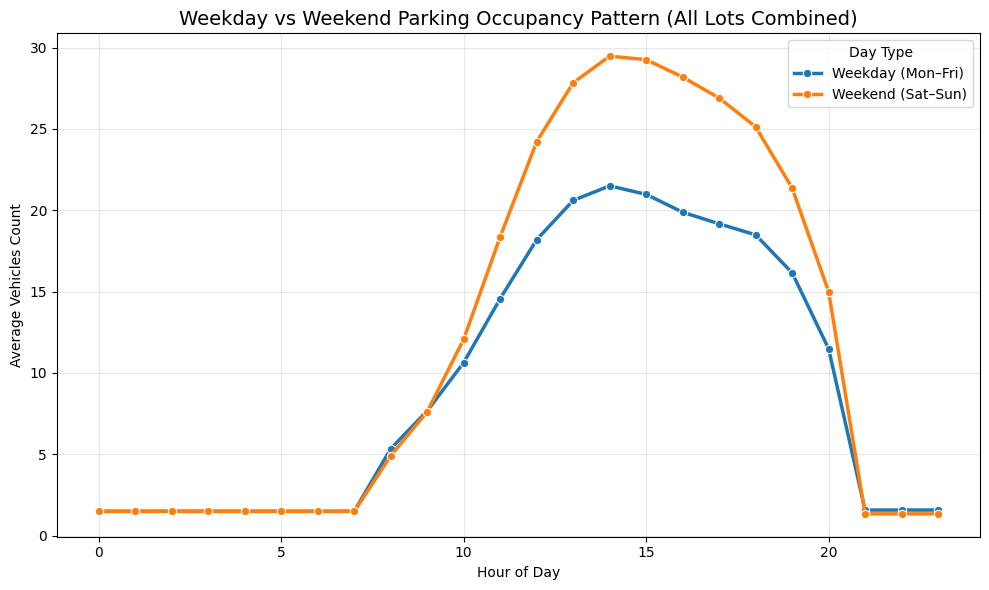

In [ ]:
# Ensure datetime format
df_parking_traffic['datetime'] = pd.to_datetime(df_parking_traffic['datetime'], errors='coerce')

# Extract hour and day of week
df_parking_traffic['hour'] = df_parking_traffic['datetime'].dt.hour
df_parking_traffic['day_of_week'] = df_parking_traffic['datetime'].dt.dayofweek  # Monday=0, Sunday=6
df_parking_traffic['is_weekend'] = df_parking_traffic['day_of_week'] >= 5

# Group by hour and weekend flag
hourly_week = (
    df_parking_traffic.groupby(['hour', 'is_weekend'])['vehicles_count']
    .mean()
    .reset_index()
)

# Replace True/False with labels
hourly_week['Day Type'] = hourly_week['is_weekend'].map({True: 'Weekend (Sat–Sun)', False: 'Weekday (Mon–Fri)'})

# --- Plot ---
plt.figure(figsize=(10,6))
sns.lineplot(
    data=hourly_week, x='hour', y='vehicles_count',
    hue='Day Type', marker='o', linewidth=2.5
)
plt.title("Weekday vs Weekend Parking Occupancy Pattern (All Lots Combined)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicles Count")
plt.grid(alpha=0.3)
plt.legend(title="Day Type")
plt.tight_layout()
plt.show()

In [ ]:
df_city.columns

Index(['datetime', 'vehicles_count', 'total_amount', 'revenue_generated',
       'resident_count', 'parking_count', 'pay_phone_count', 'pay_card_count',
       'pay_cash_count', 'hour', 'day_of_week_num', 'is_weekend',
       'is_holiday_AB', 'is_holiday_BC', 'is_holiday_US', 'is_spring_break',
       'is_stampede', 'max_temp', 'min_temp', 'mean_temp', 'total_precip',
       'snow_on_ground', 'has_precip', 'is_bad_weather', 'Bridge_Northbound',
       'Bridge_Southbound', 'EastEntrance_Northbound',
       'EastEntrance_Southbound', 'MountainAve_Northbound',
       'MountainAve_Southbound', 'WestEntrance_Northbound',
       'WestEntrance_Southbound', 'global_resident_ratio', 'total_traffic',
       'month', 'bridge_total'],
      dtype='object')

## Final Feature Engineering

In [ ]:
# 1. PREPARATION
# ---------------------------------------------------------
# Work on the aggregated city-level dataset
df_ml = df_city.copy().sort_values('datetime')
target = 'vehicles_count'

# Automatically detect traffic-related columns
traffic_cols = [c for c in df_ml.columns if 'Entrance' in c or 'Bridge' in c or 'Mountain' in c]

print(f"⚙️ Starting Feature Engineering for dataset with {len(df_ml)} rows...")


# 2. GENERATION OF TEMPORAL FEATURES (LAGS & WINDOWS)
# ---------------------------------------------------------

# A. Target Lags (Autoregression)
# How was parking occupancy...?
df_ml['target_lag3'] = df_ml[target].shift(3)     # 3 hours ago
df_ml['target_lag24'] = df_ml[target].shift(24)   # 1 day ago (same hour yesterday)
df_ml['target_lag168'] = df_ml[target].shift(168) # 1 week ago (same hour last week)

# B. Traffic Lags (Causality)
# Traffic precedes occupancy — we use Lag 3 (traffic 3 hour before)
for col in traffic_cols:
    df_ml[f'{col}_lag3'] = df_ml[col].shift(3)

# C. Rolling Windows (Recent Trends)
# Rolling mean of the last 3 hours (shifted to avoid data leakage)
df_ml['rolling_mean_3h'] = df_ml[target].shift(3).rolling(window=3).mean()
# Rolling Std. of last 24 hours (how volatile has occupancy been?)
df_ml['rolling_std_24h'] = df_ml[target].shift(3).rolling(window=24).std()


# 3. FINAL CLEANING
# ---------------------------------------------------------
# Creating a 168-hour lag (1 week) produces the first 168 rows with NaN.
# These must be removed so models do not fail during training.
print(f"   📉 Dropping initial rows with missing lag values...")
df_ml.dropna(inplace=True)

# Ensure datetime becomes the index
df_ml.set_index('datetime', inplace=True)

# Remove leftover text-based columns (e.g., 'day_of_week' as text)
if 'day_of_week' in df_ml.columns:
    df_ml.drop(columns=['day_of_week'], inplace=True)


⚙️ Starting Feature Engineering for dataset with 10615 rows...
   📉 Dropping initial rows with missing lag values...


In [ ]:
df_ml.head()

,vehicles_count,total_amount,revenue_generated,resident_count,parking_count,pay_phone_count,pay_card_count,pay_cash_count,hour,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,has_precip,is_bad_weather,Bridge_Northbound,Bridge_Southbound,EastEntrance_Northbound,EastEntrance_Southbound,MountainAve_Northbound,MountainAve_Southbound,WestEntrance_Northbound,WestEntrance_Southbound,global_resident_ratio,total_traffic,month,bridge_total,target_lag3,target_lag24,target_lag168,Bridge_Northbound_lag3,Bridge_Southbound_lag3,EastEntrance_Northbound_lag3,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-08 19:00:00,180,1270.0,505.623340,66,171,107,61,14,19,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,221.0,286.0,103.0,128.0,55.0,28.0,127.0,154.0,0.366667,1102.0,2024-01,286.0,257.0,31.0,20.0,295.0,362.0,155.0,197.0,78.0,74.0,256.0,322.0,267.333333,123.230953
2024-01-08 20:00:00,114,966.0,360.290007,34,107,68,41,5,20,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,128.0,209.0,70.0,83.0,38.0,25.0,96.0,78.0,0.298246,727.0,2024-01,209.0,264.0,67.0,60.0,314.0,358.0,228.0,217.0,64.0,52.0,260.0,367.0,266.666667,115.755482
2024-01-08 21:00:00,1,8.0,4.000000,0,0,1,0,0,21,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,111.0,192.0,38.0,66.0,21.0,18.0,60.0,49.0,0.000000,555.0,2024-01,192.0,222.0,153.0,151.0,299.0,418.0,183.0,222.0,70.0,40.0,231.0,266.0,247.666667,106.326601
2024-01-08 22:00:00,1,8.0,4.000000,0,0,1,0,0,22,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,85.0,132.0,37.0,50.0,25.0,11.0,50.0,35.0,0.000000,425.0,2024-01,132.0,180.0,283.0,309.0,221.0,286.0,103.0,128.0,55.0,28.0,127.0,154.0,222.000000,98.505462
2024-01-08 23:00:00,1,8.0,4.000000,0,0,1,0,0,23,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,60.0,86.0,32.0,40.0,17.0,9.0,24.0,30.0,0.000000,298.0,2024-01,86.0,114.0,362.0,485.0,128.0,209.0,70.0,83.0,38.0,25.0,96.0,78.0,172.000000,95.498682


/tmp/ipython-input-2980858799.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm_r")


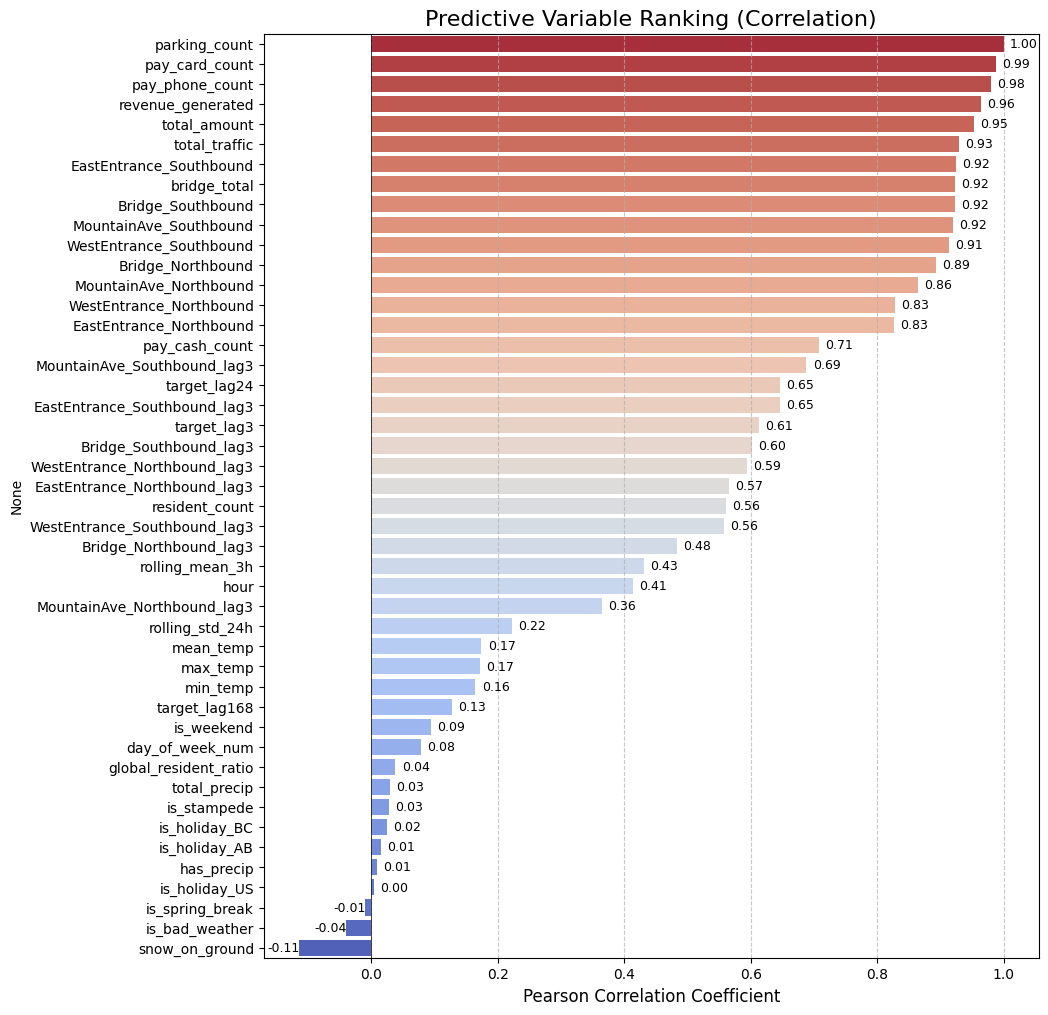

🔝 TOP 10 Variables:
parking_count              0.999721
pay_card_count             0.987480
pay_phone_count            0.979192
revenue_generated          0.963452
total_amount               0.952462
total_traffic              0.929592
EastEntrance_Southbound    0.923758
bridge_total               0.922336
Bridge_Southbound          0.922336
MountainAve_Southbound     0.919702
Name: vehicles_count, dtype: float64


In [ ]:
# 1. COMPUTE CORRELATION (Numeric Only)
# ---------------------------------------------------------
# FIX: numeric_only=True ignores text/date columns that normally trigger an error
corr_matrix = df_ml.corr(numeric_only=True)

# Filter only the correlation with the target variable
target_corr = corr_matrix['vehicles_count'].drop('vehicles_count')  # Remove self-correlation (1.0)
target_corr = target_corr.sort_values(ascending=False)

# 2. VISUALIZATION (Ranking)
# ---------------------------------------------------------
plt.figure(figsize=(10, 12))

# Color map: Red (Positive) to Blue (Negative)
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm_r")

plt.title("Predictive Variable Ranking (Correlation)", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Value Labels
for index, value in enumerate(target_corr.values):
    # Visual adjustment so labels don’t overlap the bar
    offset = 0.01 if value >= 0 else -0.05
    plt.text(value + offset, index, f'{value:.2f}', va='center', fontsize=9)

plt.show()

# 3. REPORT
print("🔝 TOP 10 Variables:")
print(target_corr.head(10))


In [ ]:
# 1. BLACKLIST (Data Leakage Prevention)
# Variables that occur simultaneously with the target and therefore cannot be known in advance
cols_to_drop_leakage = [
    # Target breakdown (partial components of the target itself)
    'parking_count',
    'resident_count',
    'pay_card_count',
    'pay_phone_count',
    'pay_cash_count',
    'extension_count',
    'global_resident_ratio',

    # Financial metrics (these are consequences, not causes)
    'revenue_generated',
    'total_amount',
    'avg_hourly_rate',  # Sometimes known beforehand (fixed price), but if dynamic, better to remove

    # CURRENT traffic variables (simultaneous with the target)
    # In pure forecasting, we only use traffic from 3 hour ago (lags).
    # If you have real-time traffic, you may keep the non-lag columns,
    # but to enforce strict forecasting rules, we use only lagged traffic.
    # For now, REMOVE current traffic columns to force the model to use past information only.
    'total_traffic','bridge_total',
    'Bridge_Northbound', 'Bridge_Southbound',
    'EastEntrance_Northbound', 'EastEntrance_Southbound',
    'MountainAve_Northbound', 'MountainAve_Southbound',
    'WestEntrance_Northbound', 'WestEntrance_Southbound'
]

# Remove only columns that actually exist in the dataframe
cols_existing_drop = [c for c in cols_to_drop_leakage if c in df_ml.columns]

print(f"🗑️ Removing {len(cols_existing_drop)} Data Leakage columns...")
df_model_ready = df_ml.drop(columns=cols_existing_drop)

# 2. FINAL VALIDATION
print("\n✅ Predictor variables to be used by the model:")
print(df_model_ready.columns.tolist())


🗑️ Removing 18 Data Leakage columns...

✅ Predictor variables to be used by the model:
['vehicles_count', 'hour', 'day_of_week_num', 'is_weekend', 'is_holiday_AB', 'is_holiday_BC', 'is_holiday_US', 'is_spring_break', 'is_stampede', 'max_temp', 'min_temp', 'mean_temp', 'total_precip', 'snow_on_ground', 'has_precip', 'is_bad_weather', 'month', 'target_lag3', 'target_lag24', 'target_lag168', 'Bridge_Northbound_lag3', 'Bridge_Southbound_lag3', 'EastEntrance_Northbound_lag3', 'EastEntrance_Southbound_lag3', 'MountainAve_Northbound_lag3', 'MountainAve_Southbound_lag3', 'WestEntrance_Northbound_lag3', 'WestEntrance_Southbound_lag3', 'rolling_mean_3h', 'rolling_std_24h']


/tmp/ipython-input-3162055831.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm_r")


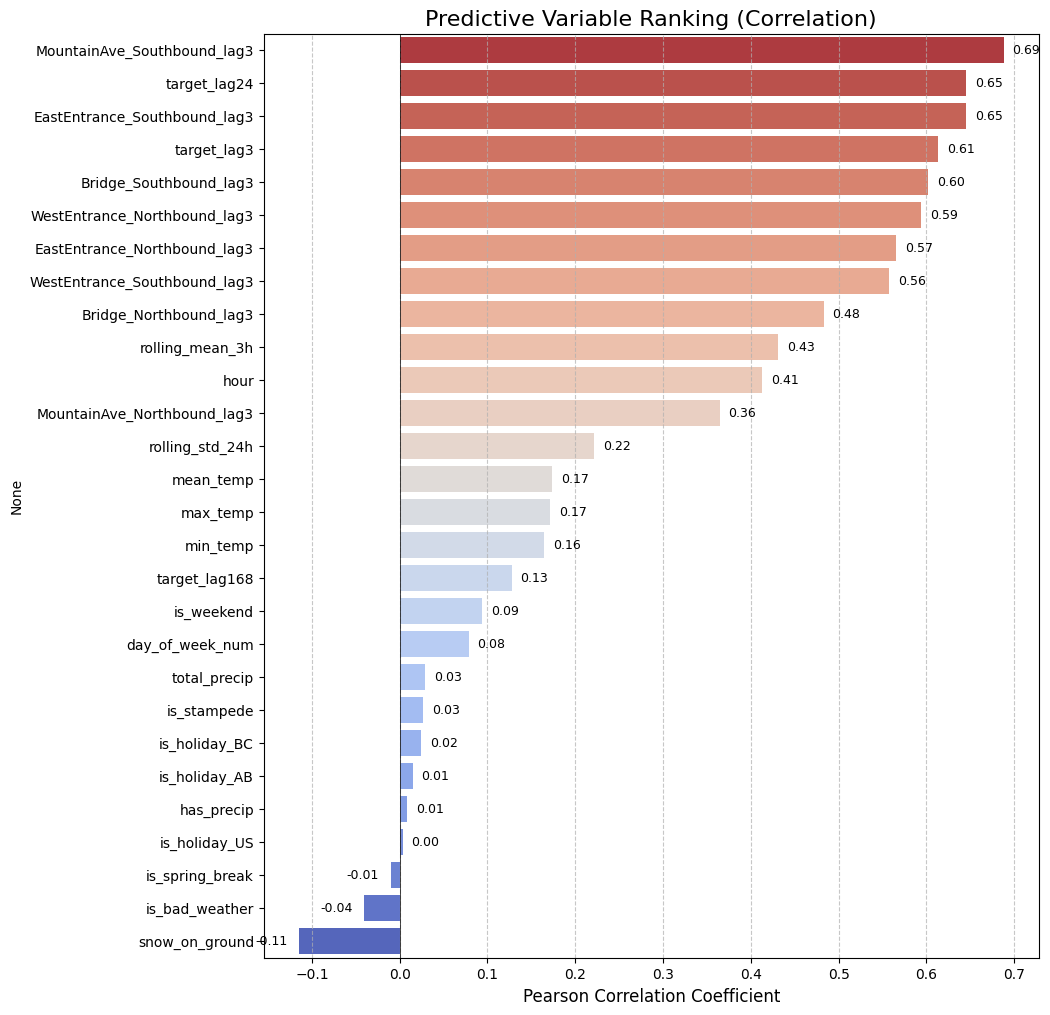

🔝 TOP 10 Variables:
MountainAve_Southbound_lag3     0.687794
target_lag24                    0.645418
EastEntrance_Southbound_lag3    0.645353
target_lag3                     0.613330
Bridge_Southbound_lag3          0.601944
WestEntrance_Northbound_lag3    0.594250
EastEntrance_Northbound_lag3    0.565665
WestEntrance_Southbound_lag3    0.557646
Bridge_Northbound_lag3          0.482882
rolling_mean_3h                 0.430916
Name: vehicles_count, dtype: float64


In [ ]:
# 1. COMPUTE CORRELATION (Numeric Only)
# ---------------------------------------------------------
# FIX: numeric_only=True ignores text/date columns that normally trigger an error
corr_matrix = df_model_ready.corr(numeric_only=True)

# Filter only the correlation with the target variable
target_corr = corr_matrix['vehicles_count'].drop('vehicles_count')  # Remove self-correlation (1.0)
target_corr = target_corr.sort_values(ascending=False)

# 2. VISUALIZATION (Ranking)
# ---------------------------------------------------------
plt.figure(figsize=(10, 12))

# Color map: Red (Positive) to Blue (Negative)
sns.barplot(x=target_corr.values, y=target_corr.index, palette="coolwarm_r")

plt.title("Predictive Variable Ranking (Correlation)", fontsize=16)
plt.xlabel("Pearson Correlation Coefficient", fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Value Labels
for index, value in enumerate(target_corr.values):
    # Visual adjustment so labels don’t overlap the bar
    offset = 0.01 if value >= 0 else -0.05
    plt.text(value + offset, index, f'{value:.2f}', va='center', fontsize=9)

plt.show()

# 3. REPORT
print("🔝 TOP 10 Variables:")
print(target_corr.head(10))

In [ ]:
# Assume df_model_ready is your dataset before exporting
df_eng = df_model_ready.copy()

# 1. DEFINE INFLOW AND OUTFLOW VARIABLES (Based on Banff Geography)
# -----------------------------------------------------------------------

# ENTERING downtown (this fills parking lots)
# - East/West: Coming from the highway (South)
# - Bridge: Coming from the mountain area (North)
inflow_cols = [
    'EastEntrance_Southbound_lag3',
    'WestEntrance_Southbound_lag3',
    'Bridge_Northbound_lag3'      # Note: Crossing the bridge INTO downtown
]

# LEAVING downtown (this frees parking spaces)
# - East/West: Heading toward the highway (North)
# - Bridge: Going toward the mountain area (South)
outflow_cols = [
    'EastEntrance_Northbound_lag3',
    'WestEntrance_Northbound_lag3',
    'Bridge_Southbound_lag3'      # Note: Crossing the bridge AWAY from downtown
]

# 2. COMPUTE AGGREGATED METRICS
# -----------------------------------------------------------------------

# A. Total Inflow (The “Avalanche”)
# Helps the model detect sudden high-volume arrivals
df_eng['total_downtown_inflow_lag3'] = df_eng[inflow_cols].sum(axis=1)

# B. Total Outflow (The “Exodus”)
# Helps the model anticipate when parking will empty out
df_eng['total_downtown_outflow_lag3'] = df_eng[outflow_cols].sum(axis=1)

# C. Net Accumulation (Inflow – Outflow)
# Positive → the town is filling up; Negative → it is emptying
df_eng['net_traffic_accumulation_lag3'] = df_eng['total_downtown_inflow_lag3'] - df_eng['total_downtown_outflow_lag3']
# Hypothesis: If Inflow is high AND Outflow is high, the town is in a state of chaos and parking lots are full.
df_eng['total_traffic_volume_lag3'] = df_eng['total_downtown_inflow_lag3'] + df_eng['total_downtown_outflow_lag3']

# 3. QUICK VALIDATION
# -----------------------------------------------------------------------
# Check how strongly these new engineered variables relate to actual occupancy
print("📊 Impact of new Flow Features:")
new_vars = ['total_downtown_inflow_lag3', 'total_downtown_outflow_lag3',
            'net_traffic_accumulation_lag3','total_traffic_volume_lag3', 'vehicles_count']
print(df_eng[new_vars].corr()['vehicles_count'])



📊 Impact of new Flow Features:
total_downtown_inflow_lag3       0.576412
total_downtown_outflow_lag3      0.616087
net_traffic_accumulation_lag3   -0.097099
total_traffic_volume_lag3        0.599804
vehicles_count                   1.000000
Name: vehicles_count, dtype: float64


In [ ]:
# 1. TRAFFIC FEATURE SELECTION
# We keep only the features that showed predictive power (> 0.5)
# and remove the one that performed poorly.

features_to_drop = ['net_traffic_accumulation_lag3']

# Check if the column exists before dropping it
# (avoids errors if you run this cell more than once)
cols_actually_dropping = [c for c in features_to_drop if c in df_eng.columns]
df_eng.drop(columns=cols_actually_dropping, inplace=True)

print(f"🗑️ Variables removed due to low correlation: {cols_actually_dropping}")

# 2. FINAL FEATURE LIST
# Good practice: print what you are feeding into the model
print("\n🚀 FINAL FEATURES USED BY THE MODEL:")
print("-" * 30)
final_cols = df_eng.columns.tolist()
for col in final_cols:
    print(f"- {col}")


🗑️ Variables removed due to low correlation: []

🚀 FINAL FEATURES USED BY THE MODEL:
------------------------------
- vehicles_count
- hour
- day_of_week_num
- is_weekend
- is_holiday_AB
- is_holiday_BC
- is_holiday_US
- is_spring_break
- is_stampede
- max_temp
- min_temp
- mean_temp
- total_precip
- snow_on_ground
- has_precip
- is_bad_weather
- month
- target_lag3
- target_lag24
- target_lag168
- Bridge_Northbound_lag3
- Bridge_Southbound_lag3
- EastEntrance_Northbound_lag3
- EastEntrance_Southbound_lag3
- MountainAve_Northbound_lag3
- MountainAve_Southbound_lag3
- WestEntrance_Northbound_lag3
- WestEntrance_Southbound_lag3
- rolling_mean_3h
- rolling_std_24h
- total_downtown_inflow_lag3
- total_downtown_outflow_lag3
- total_traffic_volume_lag3


In [ ]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10447 entries, 2024-01-08 19:00:00 to 2025-09-01 00:00:00
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   vehicles_count                10447 non-null  int64  
 1   hour                          10447 non-null  int64  
 2   day_of_week_num               10447 non-null  int32  
 3   is_weekend                    10447 non-null  int64  
 4   is_holiday_AB                 10447 non-null  int64  
 5   is_holiday_BC                 10447 non-null  int64  
 6   is_holiday_US                 10447 non-null  int64  
 7   is_spring_break               10447 non-null  int64  
 8   is_stampede                   10447 non-null  int64  
 9   max_temp                      10447 non-null  float64
 10  min_temp                      10447 non-null  float64
 11  mean_temp                     10447 non-null  float64
 12  total_precip             

In [ ]:
# Use the time index to extract the month (1 = January, 12 = December)
df_eng['month'] = df_eng.index.month.astype(int)

In [ ]:
df_eng.head()

,vehicles_count,hour,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,has_precip,is_bad_weather,month,target_lag3,target_lag24,target_lag168,Bridge_Northbound_lag3,Bridge_Southbound_lag3,EastEntrance_Northbound_lag3,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h,total_downtown_inflow_lag3,total_downtown_outflow_lag3,total_traffic_volume_lag3
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-08 19:00:00,180,19,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,257.0,31.0,20.0,295.0,362.0,155.0,197.0,78.0,74.0,256.0,322.0,267.333333,123.230953,814.0,773.0,1587.0
2024-01-08 20:00:00,114,20,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,264.0,67.0,60.0,314.0,358.0,228.0,217.0,64.0,52.0,260.0,367.0,266.666667,115.755482,898.0,846.0,1744.0
2024-01-08 21:00:00,1,21,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,222.0,153.0,151.0,299.0,418.0,183.0,222.0,70.0,40.0,231.0,266.0,247.666667,106.326601,787.0,832.0,1619.0
2024-01-08 22:00:00,1,22,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,180.0,283.0,309.0,221.0,286.0,103.0,128.0,55.0,28.0,127.0,154.0,222.000000,98.505462,503.0,516.0,1019.0
2024-01-08 23:00:00,1,23,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,114.0,362.0,485.0,128.0,209.0,70.0,83.0,38.0,25.0,96.0,78.0,172.000000,95.498682,289.0,375.0,664.0


In [ ]:
df_banff_parking_final_optimized = df_eng.copy()

In [ ]:
df_banff_parking_final_optimized.head()

,vehicles_count,hour,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,has_precip,is_bad_weather,month,target_lag3,target_lag24,target_lag168,Bridge_Northbound_lag3,Bridge_Southbound_lag3,EastEntrance_Northbound_lag3,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h,total_downtown_inflow_lag3,total_downtown_outflow_lag3,total_traffic_volume_lag3
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-08 19:00:00,180,19,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,257.0,31.0,20.0,295.0,362.0,155.0,197.0,78.0,74.0,256.0,322.0,267.333333,123.230953,814.0,773.0,1587.0
2024-01-08 20:00:00,114,20,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,264.0,67.0,60.0,314.0,358.0,228.0,217.0,64.0,52.0,260.0,367.0,266.666667,115.755482,898.0,846.0,1744.0
2024-01-08 21:00:00,1,21,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,222.0,153.0,151.0,299.0,418.0,183.0,222.0,70.0,40.0,231.0,266.0,247.666667,106.326601,787.0,832.0,1619.0
2024-01-08 22:00:00,1,22,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,180.0,283.0,309.0,221.0,286.0,103.0,128.0,55.0,28.0,127.0,154.0,222.000000,98.505462,503.0,516.0,1019.0
2024-01-08 23:00:00,1,23,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,114.0,362.0,485.0,128.0,209.0,70.0,83.0,38.0,25.0,96.0,78.0,172.000000,95.498682,289.0,375.0,664.0


In [ ]:
df_banff_parking_final_optimized.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10447 entries, 2024-01-08 19:00:00 to 2025-09-01 00:00:00
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   vehicles_count                10447 non-null  int64  
 1   hour                          10447 non-null  int64  
 2   day_of_week_num               10447 non-null  int32  
 3   is_weekend                    10447 non-null  int64  
 4   is_holiday_AB                 10447 non-null  int64  
 5   is_holiday_BC                 10447 non-null  int64  
 6   is_holiday_US                 10447 non-null  int64  
 7   is_spring_break               10447 non-null  int64  
 8   is_stampede                   10447 non-null  int64  
 9   max_temp                      10447 non-null  float64
 10  min_temp                      10447 non-null  float64
 11  mean_temp                     10447 non-null  float64
 12  total_precip             

In [ ]:
# Sacar datetime del Índice y volverlo una columna normal
df_export = df_banff_parking_final_optimized.reset_index()

# Ahora revisa el info()
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447 entries, 0 to 10446
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime                      10447 non-null  datetime64[ns]
 1   vehicles_count                10447 non-null  int64         
 2   hour                          10447 non-null  int64         
 3   day_of_week_num               10447 non-null  int32         
 4   is_weekend                    10447 non-null  int64         
 5   is_holiday_AB                 10447 non-null  int64         
 6   is_holiday_BC                 10447 non-null  int64         
 7   is_holiday_US                 10447 non-null  int64         
 8   is_spring_break               10447 non-null  int64         
 9   is_stampede                   10447 non-null  int64         
 10  max_temp                      10447 non-null  float64       
 11  min_temp                    

In [ ]:
df_export.head()

,datetime,vehicles_count,hour,day_of_week_num,is_weekend,is_holiday_AB,is_holiday_BC,is_holiday_US,is_spring_break,is_stampede,max_temp,min_temp,mean_temp,total_precip,snow_on_ground,has_precip,is_bad_weather,month,target_lag3,target_lag24,target_lag168,Bridge_Northbound_lag3,Bridge_Southbound_lag3,EastEntrance_Northbound_lag3,EastEntrance_Southbound_lag3,MountainAve_Northbound_lag3,MountainAve_Southbound_lag3,WestEntrance_Northbound_lag3,WestEntrance_Southbound_lag3,rolling_mean_3h,rolling_std_24h,total_downtown_inflow_lag3,total_downtown_outflow_lag3,total_traffic_volume_lag3
0,2024-01-08 19:00:00,180,19,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,257.0,31.0,20.0,295.0,362.0,155.0,197.0,78.0,74.0,256.0,322.0,267.333333,123.230953,814.0,773.0,1587.0
1,2024-01-08 20:00:00,114,20,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,264.0,67.0,60.0,314.0,358.0,228.0,217.0,64.0,52.0,260.0,367.0,266.666667,115.755482,898.0,846.0,1744.0
2,2024-01-08 21:00:00,1,21,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,222.0,153.0,151.0,299.0,418.0,183.0,222.0,70.0,40.0,231.0,266.0,247.666667,106.326601,787.0,832.0,1619.0
3,2024-01-08 22:00:00,1,22,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,180.0,283.0,309.0,221.0,286.0,103.0,128.0,55.0,28.0,127.0,154.0,222.000000,98.505462,503.0,516.0,1019.0
4,2024-01-08 23:00:00,1,23,0,0,0,0,0,0,0,-8.1,-23.9,-16.0,0.0,16.0,0,0,1,114.0,362.0,485.0,128.0,209.0,70.0,83.0,38.0,25.0,96.0,78.0,172.000000,95.498682,289.0,375.0,664.0


# Save Final DataFrame to CSV

In [ ]:
# Define file name and path
file_name = "banff_parking_ml_ready.csv"

# Save the DataFrame to a CSV file
df_export.to_csv(file_name, index=False, encoding='utf-8')

# Confirm file creation
print(f"✅ DataFrame successfully saved as '{file_name}'")
print(f"Rows: {df_export.shape[0]:,} | Columns: {df_export.shape[1]}")

# Download the file directly to your computer
from google.colab import files
files.download(file_name)

✅ DataFrame successfully saved as 'banff_parking_ml_ready.csv'
Rows: 10,447 | Columns: 34


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>